# Plots for the figure that illustrats the problem

In [1]:
import torch # for some reason I need to import torch before numpy to avoid a kernel crash

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os, sys
rootpath = os.path.join(os.getcwd(), '.')
sys.path.append(rootpath)
from src.simulation import *
from src.approximation import *
from src.theory import *
from src.analysis import *
# reimport modules if they change
%load_ext autoreload
%autoreload 2

In [2]:
params = {
    'N': int(1e4),
    'K': 100,
    'mu': 0.2,
    'sigma': 0.01,
    "epsilon": 0.1,
    'seed': 1000,
    'seed_d': 1000,
    'nu' : 0.2,
}
plt.text.usetex : True
# font size
plt.rcParams.update({'font.size': 8})
# # tick size
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
kwargs_figures = {
    'transparent': True,
    'dpi': 300,
    'bbox_inches': 'tight',
}

## Illustration of the dynamic range 
Specific example

In [3]:
# set seed to a value for which database entry exists
params["seed"] = 1000

lam = 0.999
window = 10

xmin=5e-5
xmax=5e-1
ymin=-0.03
ymax=1.09

In [4]:
# load relevant information from database
import sqlite3
database = "./simulations.db"
con = sqlite3.connect(database)
cur = con.cursor()

# load function approximation from database
beta_interpolation = pd.read_sql_query(
    f"SELECT * FROM beta_interpolations WHERE N={params['N']} AND K={params['K']} AND mu={params['mu']} AND seed={params['seed']}",
    con,
)
# check that there is a unique function approximation
if not len(beta_interpolation) == 1:
    raise ValueError(
        f"No unique function approximation in database for params (either 0 or multiple entries)"
    )
print(
    f"Load beta interpolation from file: {beta_interpolation['filename'].values[0]}"
)
beta_approx = FunctionApproximation(
    filename=beta_interpolation["filename"].values[0]
)
con.close()

Load beta interpolation from file: ./dat/beta_interpolation_N=10000_K=100_mu=0.2_seed=1000.pkl


In [5]:
# parameters of the beta distribution
loc = beta_approx.params["loc"]
scale = beta_approx.params["scale"]
# support for the gaussian noise
delta = 1 / beta_approx.params["N"]
x_gauss = support_gauss(5 * params["sigma"], delta)
# pmf of the gaussian noise (needs delta for normalization)
pmf_gauss = stats.norm.pdf(x_gauss, 0, params["sigma"]) * delta 

# full support for convolution (add another delta to the right because beta distribution is calculated from the difference of the cdf)
x_beta = support_conv_pmf_gauss([0,1+delta], x_gauss)
x_noise = support_conv_pmf_gauss([0,1], x_gauss)

def pmf_noise(window, lam, h):
    a,b = beta_approx(lam, window, h)
    # pmf as difference of cdf to ensure that the pmf is normalized
    pmf = np.diff(stats.beta.cdf(x_beta, a, b, loc=loc, scale=scale))
    return np.convolve(pmf, pmf_gauss, mode="same")

pmf_o_given_h = lambda h: pmf_noise(window, lam, h)

In [6]:
# find disriminable points
# get reference distributions from mean-field solution (needs delta for normalization because in domain [0,1] with stepsize delta)
pmf_refs = [stats.norm.pdf(x_noise, mean_field_activity(lam, params['mu'], h), params['sigma'])*delta for h in [0, np.inf]]

# get dynamic range and number of discriminable states
h_range = beta_approx.input_range[beta_approx.input_names.index("h")]
hs_left = find_discriminable_inputs(pmf_o_given_h, h_range, pmf_refs, params["epsilon"], start="left")
hs_right = find_discriminable_inputs(pmf_o_given_h, h_range, pmf_refs, params["epsilon"], start="right")

In [7]:
# calculate the median and 25/75 percentiles of the noisy activity for different input rates
hs = 10**np.linspace(-5, -0, 100)   
percentile_05 = np.zeros_like(hs)
percentile_50 = np.zeros_like(hs)
percentile_95 = np.zeros_like(hs) 
for (i,h) in tqdm(enumerate(hs)):
    pmf_h = pmf_o_given_h(h)
    cdf = np.cumsum(pmf_h)
    # percentiles as the first index where the cdf is larger than the respective value
    percentile_05[i] = x_noise[np.argmax(cdf > 0.05)]
    percentile_50[i] = x_noise[np.argmax(cdf > 0.50)]
    percentile_95[i] = x_noise[np.argmax(cdf > 0.95)]


100it [00:00, 157.47it/s]


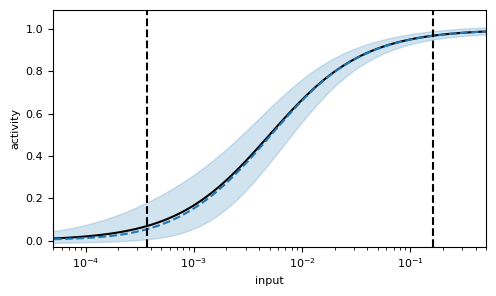

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(5, 3))

# theory
axes.plot(hs, mean_field_activity(lam, params['mu'], hs), color='black', label='theory')
ref = axes.plot(hs, percentile_50,linestyle='--')
axes.fill_between(hs, percentile_05, percentile_95, color=ref[0].get_color(), alpha=0.2)
# plot dynamic range as vertical lines from hs_left[0] to hs_right[0]
axes.axvline(hs_left[0], color='black', linestyle='--')
axes.axvline(hs_right[0], color='black', linestyle='--')
#axes.set_yscale("log")
axes.set_xscale("log")
axes.set_xlabel("input")
axes.set_ylabel("activity")
# set lims
axes.set_xlim([xmin, xmax])
axes.set_ylim([ymin, ymax])
#axes.legend()
plt.tight_layout()
plt.show()

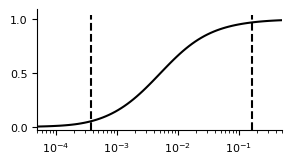

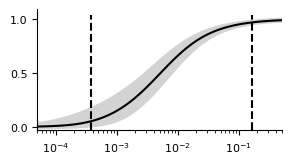

In [9]:
for version in ["MF", "full"]:
    cm = 1/2.54  # centimeters in inches
    fig, axes = plt.subplots(1,1, figsize=(8*cm, 4*cm))
    axes = [axes]

    ####### Left part of figure with response
    axes[0].spines['right'].set_visible(False)
    axes[0].spines['top'].set_visible(False)
    # unset tickslabels
    # set ticks
    axes[0].set_yticks([0,0.5,1])
    # set lims
    axes[0].set_xlim([xmin, xmax])
    axes[0].set_ylim([ymin, ymax])
    axes[0].set_xscale("log")

    axes[0].plot(hs, percentile_50, color='black')
    if version == "full":
        axes[0].fill_between(hs, percentile_05, percentile_95, color='lightgray')

    # plot dynamic range bounds from 0.05 to 0.95
    axes[0].axvline(hs_left[0], ymax=0.95, color='black', linestyle='--')
    axes[0].axvline(hs_right[0], ymax=0.95, color='black', linestyle='--')

    fig.savefig(f"./figures_talk/fig_dynamic_range_{version}.pdf", **kwargs_figures)

## Results

In [10]:
filename_inf = f"results/results_analytic_inf_N{params['N']}_mu{params['mu']}_epsilon{params['epsilon']}_sigma{params['sigma']}.txt"
if os.path.isfile(filename_inf):
    lams_inf, drs_inf, nds_inf = np.loadtxt(filename_inf).T
    print(lams_inf)
else:
    raise ValueError("file not found")

[0.         0.13403568 0.25010579 0.35061837 0.43765867 0.51303247
 0.5783035  0.63482587 0.68377223 0.72615804 0.76286263 0.7946475
 0.82217206 0.84600735 0.86664786 0.8845218  0.9        0.91340357
 0.92501058 0.93506184 0.94376587 0.95130325 0.95783035 0.96348259
 0.96837722 0.9726158  0.97628626 0.97946475 0.98221721 0.98460073
 0.98666479 0.98845218 0.99       0.99134036 0.99250106 0.99350618
 0.99437659 0.99513032 0.99578303 0.99634826 0.99683772 0.99726158
 0.99762863 0.99794647 0.99822172 0.99846007 0.99866648 0.99884522
 0.999      0.99913404 0.99925011 0.99935062 0.99943766 0.99951303
 0.9995783  0.99963483 0.99968377 0.99972616 0.99976286 0.99979465
 0.99982217 0.99984601 0.99986665 0.99988452 0.9999    ]


In [11]:
filename_0 = f"results/results_analytic_0_N{params['N']}_mu{params['mu']}_epsilon{params['epsilon']}_sigma{params['sigma']}.txt"

if os.path.isfile(filename_0):
    lams_0, drs_0, nds_0 = np.loadtxt(filename_0).T 
else: 
    raise ValueError("file not found")

In [12]:
import sqlite3
con = sqlite3.connect('simulations_nu0.2.db')
cur = con.cursor()
# load dataframe from table
sub_results = pd.read_sql_query(f"SELECT * FROM results WHERE N={params['N']} AND K={params['K']} AND mu={params['mu']} AND sigma={params['sigma']} AND epsilon={params['epsilon']}", con)
sub_results.drop(columns=['N', 'K', 'mu', 'sigma', 'epsilon'], inplace=True)
con.close()

sub_results.seed.unique()

windows = np.sort(sub_results["window"].unique())
focus_windows = [1e0,1e1,1e2,1e3,1e4]
focus_legends = ["$10^0$ ms", "$10^1$ ms", "$10^2$ ms", "$10^3$ ms", "$10^4$ ms"]
seeds = np.sort(sub_results.seed.unique())
# seeds = [1000,]
print(seeds)

sub_focus_lam = [[] for i in range(len(focus_windows))]
sub_focus_nds = [[] for i in range(len(focus_windows))]
sub_focus_drs = [[] for i in range(len(focus_windows))]
sub_lam_max_nds = [[] for i in range(len(windows))]
sub_lam_max_drs = [[] for i in range(len(windows))]
# iterate over all windows
for (i,window) in enumerate(windows):
    # reduce dataframe to current window
    sel = sub_results[sub_results["window"] == window]
    for (s, seed) in enumerate(seeds):
        # load file
        filename = sub_results[(sub_results["window"] == window) & (sub_results["seed"] == seed)].filename.values[0]
        # reduce filename to the path from ./results/
        filename = filename[filename.find("results/"):] 
        lams_data, drs_data, nds_data = np.loadtxt(f"{filename}", skiprows=1, unpack=True)
        # find lamda value of maximum from left and from right
        sub_lam_max_nds[i].append([lams_data[np.argmax(nds_data)], lams_data[len(nds_data) - np.argmax(nds_data[::-1]) - 1]])
        sub_lam_max_drs[i].append([lams_data[np.argmax(drs_data)], lams_data[len(drs_data) - np.argmax(drs_data[::-1]) - 1]])
        if not len(lams_data) > 60:
            print("problem with result {}_{}".format(window, seed))
        if window in focus_windows:
            sub_focus_lam[focus_windows.index(window)].append(lams_data)
            sub_focus_nds[focus_windows.index(window)].append(nds_data)
            sub_focus_drs[focus_windows.index(window)].append(drs_data)

[1000 1001 1002 1003 1004 1005 1006 1007 1008 1009]


In [13]:
from matplotlib.colors import LinearSegmentedColormap
custom_colors = [
    (0, "white"),
    (0.3, "#FEEB65"),
    (0.65, "#E4521B"),
    (0.85, "#4D342F"),
    (1, "black"),
]
cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors, N=512)
focus_colors = [cmap( (idx+1) / (len(focus_windows)+1) ) for idx in range(len(focus_windows))]
print(focus_colors)

[(0.9978256142639704, 0.9565122852794086, 0.6651445966514459, 1.0), (0.9865579108355671, 0.8655440258295098, 0.36898156522883124, 1.0), (0.9375300805253609, 0.5770341013117577, 0.22944081742285957, 1.0), (0.8428398756762985, 0.3113809907524655, 0.11267411074018642, 1.0), (0.3503415064655997, 0.21353363263113462, 0.17790568282107366, 1.0)]


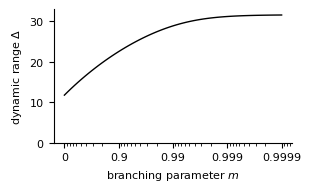

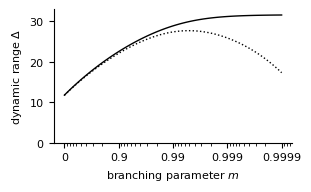

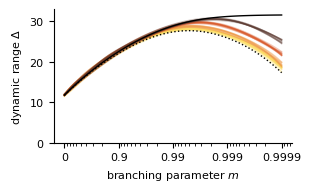

In [15]:
# set figure size to max width (Nature=18cm, APS=17.2cm)
cm = 1/2.54  # centimeters in inches
for version in ["MF", "FP", "full"]:
    fig, ax = plt.subplots(1,1, figsize=(8*cm,5*cm))
    ax = [ax]
    #fig, ax = plt.subplots(1, 2, figsize=(10,4))
    if version == "full":
        for (i,window) in enumerate(focus_windows):
            for (s, seed) in enumerate(seeds):
                ax[0].plot(1-sub_focus_lam[i][s], sub_focus_drs[i][s], color=focus_colors[i], alpha=0.3, linewidth=1.0)

    # dynamic range
    ax[0].plot(1 - lams_inf, drs_inf, color="black", linewidth=1.0)
    if version in ["FP", "full"]:
        ax[0].plot(1 - lams_0, drs_0, color="black", linestyle='dotted', linewidth=1.0)
    ax[0].set_xlabel("branching parameter $m$")
    ax[0].set_ylim(0, 33)
    ax[0].set_ylabel("dynamic range $\Delta$")
    ax[0].set_xscale("log")
    ax[0].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
    ax[0].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
    ax[0].invert_xaxis()
    # remove boundaries top and right
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig(f"figures_talk/fig_results_dynamic_range_{version}.pdf", **kwargs_figures)